# Convolutional one dimension layers for time series

In [1]:
from utilities.std_imports import *
from utilities.tf_imports import *

import seaborn as sns
from scipy import stats

import sklearn.metrics as skm
import sklearn.preprocessing as skp

pd.options.display.float_format = '{:.1f}'.format
pd.set_option('mode.chained_assignment', None)
plt.style.use('ggplot')

### Helper functions

In [32]:
def feature_normalize(ds):
    mu = np.mean(ds, axis=0)
    sigma = np.std(ds, axis=0)
    return (ds - mu)/sigma

def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, cmap="coolwarm", linecolor='white', linewidths=1, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

def show_df_info(df, head=20):
    print("Number of columns in the dataframe: %i" % (df.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (df.shape[0]))
    print("First 20 rows of the dataframe:\n")
    display(df.head(head))    

def read_data(file_path):
    column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)
    df['z-axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['z-axis'] = df['z-axis'].apply(np.float)
    df.dropna(axis=0, how='any', inplace=True)
    return df

def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def segmentation(df, time_steps, step, label_name):
    n_features = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)

    return reshaped_segments, labels

### Load data

In [33]:
df = read_data(csv_path + 'time_series/WISDM/WISDM_ar_v1.1_raw.txt')
show_df_info(df, 20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


### Data analysis

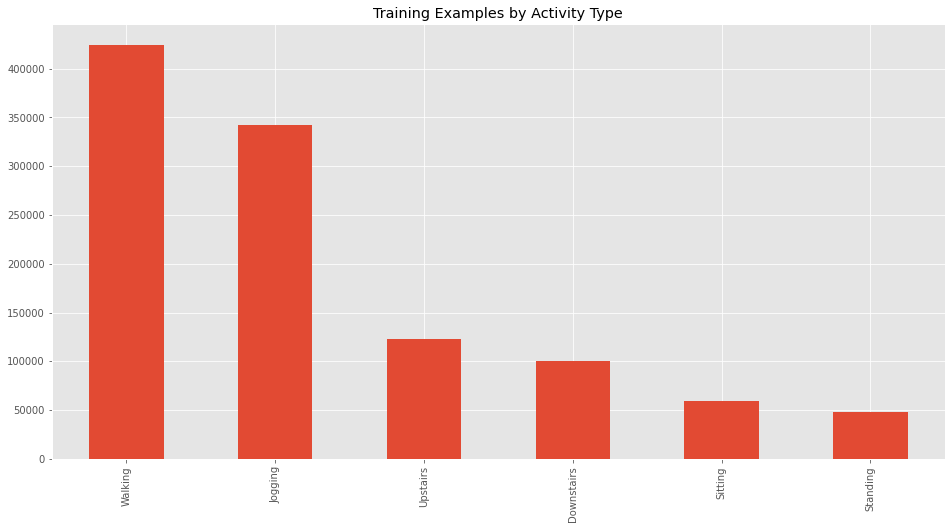

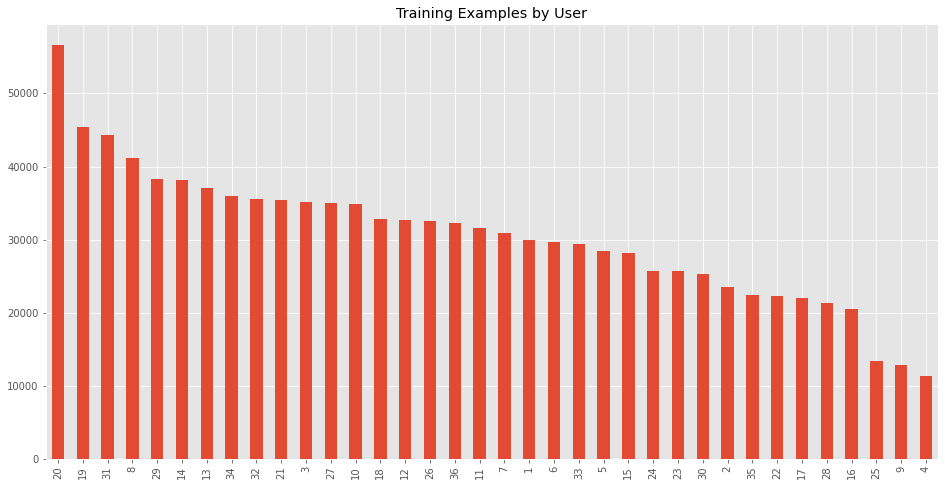

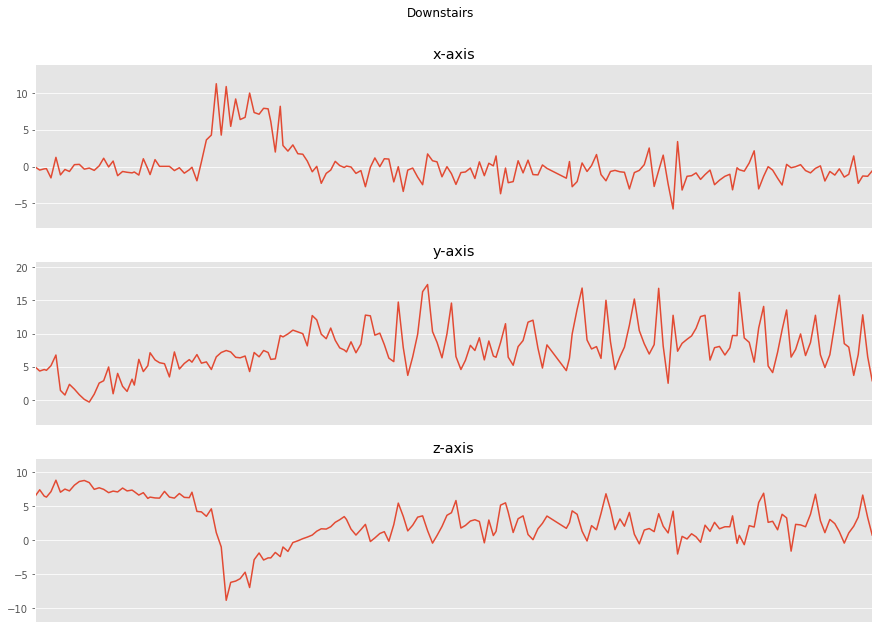

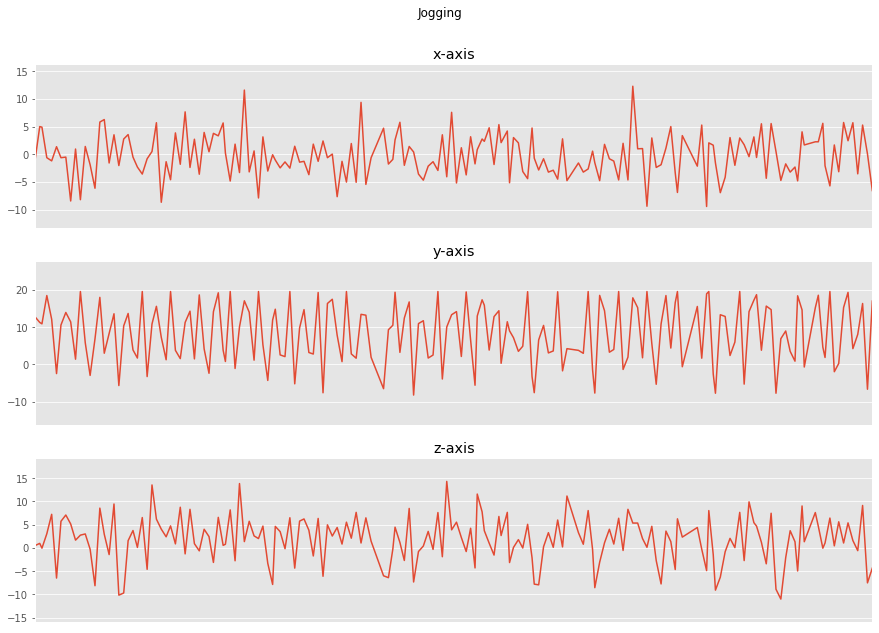

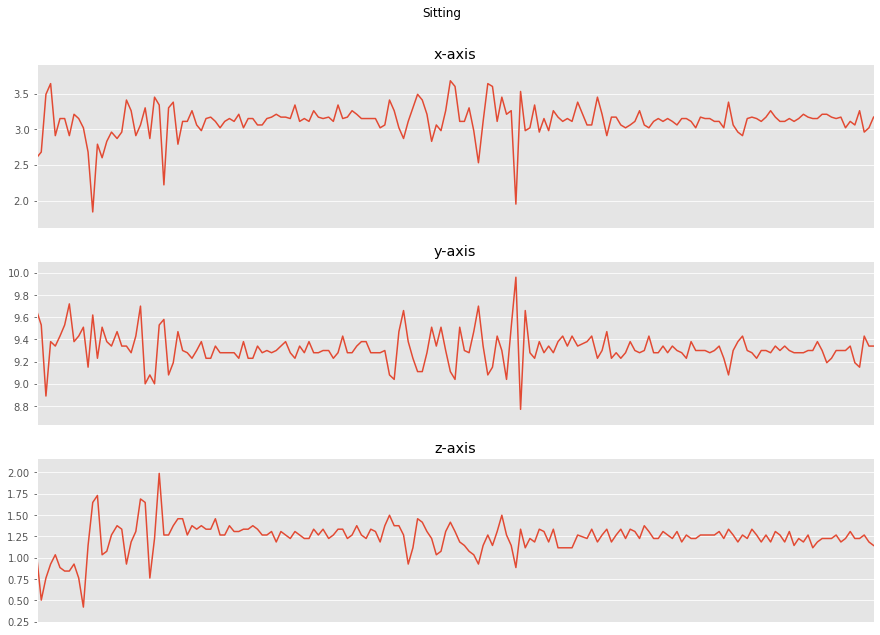

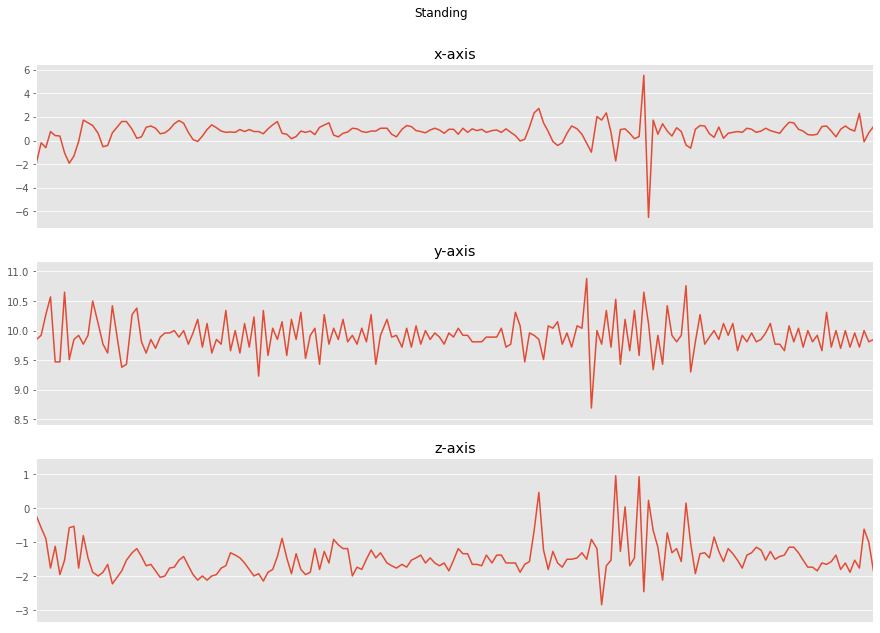

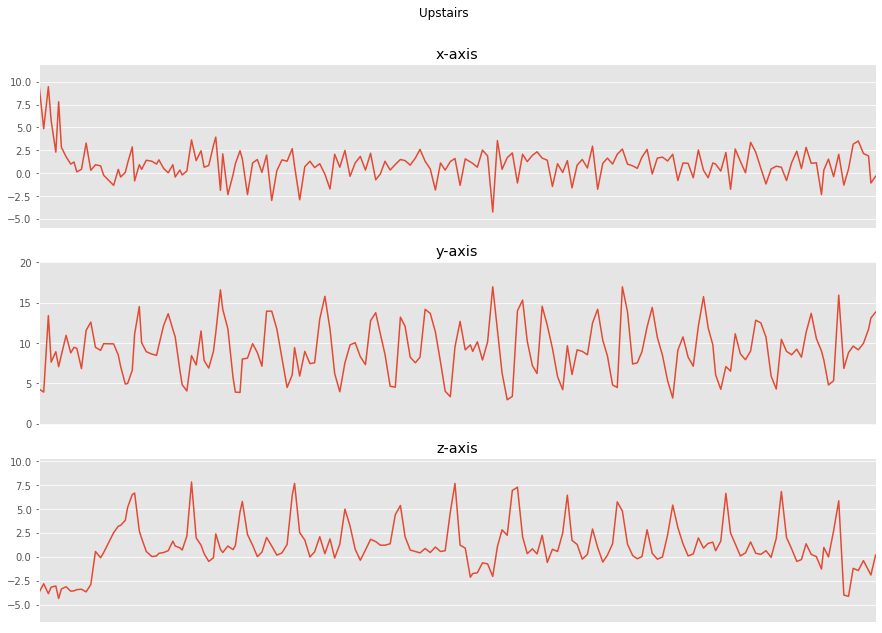

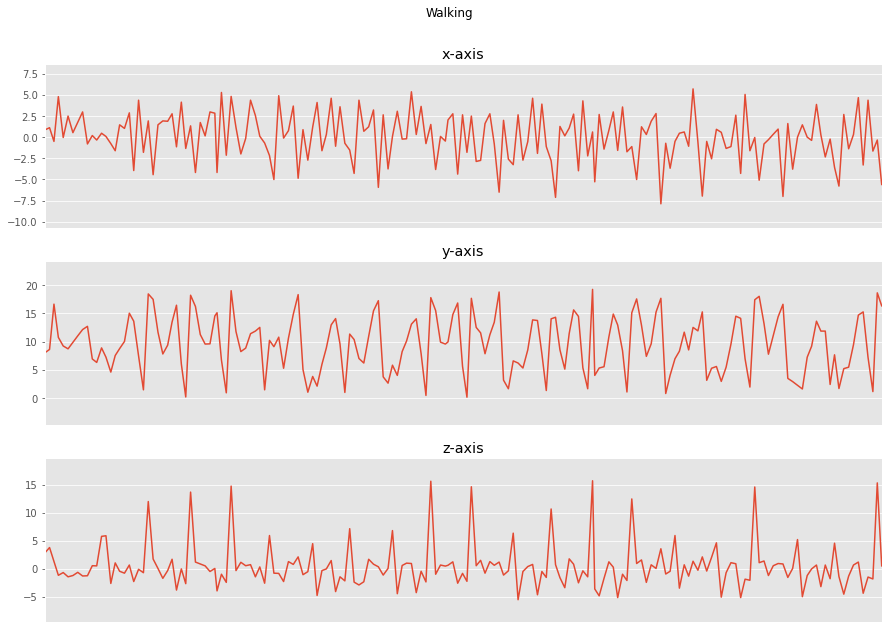

In [34]:
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
# The number of steps within one time segment
mw = 80
# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS, then there is no overlap between the segments
mw_dist = 40

plt.figure(figsize=[16,8])
df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()

plt.figure(figsize=[16,8])
df['user-id'].value_counts().plot(kind='bar', title='Training Examples by User')
plt.show()

for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

### Prepare data

In [35]:
label = 'ActivityEncoded'
le = skp.LabelEncoder()
df[label] = le.fit_transform(df["activity"].values.ravel()) # to int

# train/test split
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# normalization
df_train['x-axis'] = feature_normalize(df['x-axis'])
df_train['y-axis'] = feature_normalize(df['y-axis'])
df_train['z-axis'] = feature_normalize(df['z-axis'])
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

# Reshape 
x_train, y_train = segmentation(df_train, mw, mw_dist, label)
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

# Set input_shape / reshape for Keras
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding 
y_train = tku.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (20868, 240)
input_shape: 240
New y_train shape:  (20868, 6)


### Build model

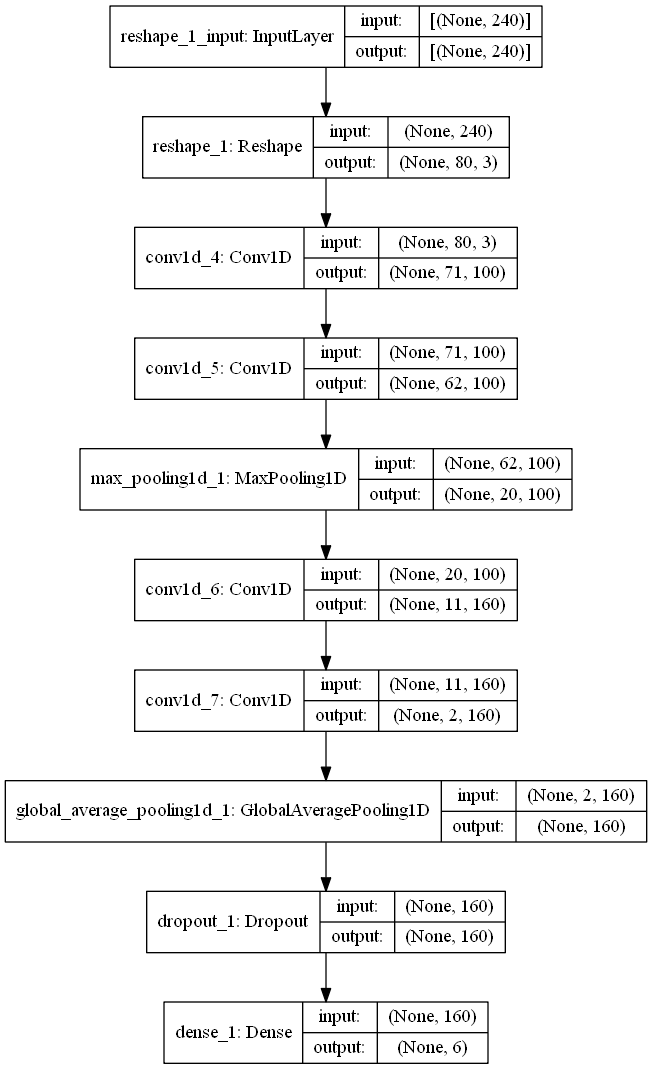

In [36]:
model = tkm.Sequential()
model.add(tkl.Reshape((mw, num_sensors), input_shape=(input_shape,)))
model.add(tkl.Conv1D(100, 10, activation='relu', input_shape=(mw, num_sensors)))
model.add(tkl.Conv1D(100, 10, activation='relu'))
model.add(tkl.MaxPooling1D(3))
model.add(tkl.Conv1D(160, 10, activation='relu'))
model.add(tkl.Conv1D(160, 10, activation='relu'))
model.add(tkl.GlobalAveragePooling1D())
model.add(tkl.Dropout(0.5))
model.add(tkl.Dense(num_classes, activation='softmax'))
tku.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [tkc.ModelCheckpoint(filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True), tkc.EarlyStopping(monitor='accuracy', patience=1)]
history = model.fit(x_train, y_train, batch_size=400, epochs=50, callbacks=callbacks, validation_split=0.2, verbose=1)

Epoch 1/50
42/42 [==============================] - 6s 120ms/step - loss: 1.0121 - accuracy: 0.6082 - val_loss: 0.5764 - val_accuracy: 0.8083
Epoch 2/50
42/42 [==============================] - 5s 111ms/step - loss: 0.3770 - accuracy: 0.8528 - val_loss: 0.5478 - val_accuracy: 0.8196
Epoch 3/50
42/42 [==============================] - 5s 115ms/step - loss: 0.2564 - accuracy: 0.9115 - val_loss: 0.5948 - val_accuracy: 0.8280
Epoch 4/50
42/42 [==============================] - 5s 114ms/step - loss: 0.1816 - accuracy: 0.9369 - val_loss: 0.6056 - val_accuracy: 0.8083
Epoch 5/50
42/42 [==============================] - 5s 115ms/step - loss: 0.1472 - accuracy: 0.9532 - val_loss: 0.5984 - val_accuracy: 0.8220
Epoch 6/50
42/42 [==============================] - 5s 115ms/step - loss: 0.1360 - accuracy: 0.9559 - val_loss: 0.6777 - val_accuracy: 0.8088
Epoch 7/50
42/42 [==============================] - 5s 121ms/step - loss: 0.1219 - accuracy: 0.9616 - val_loss: 0.6714 - val_accuracy: 0.8126
Epoch 

### Validation

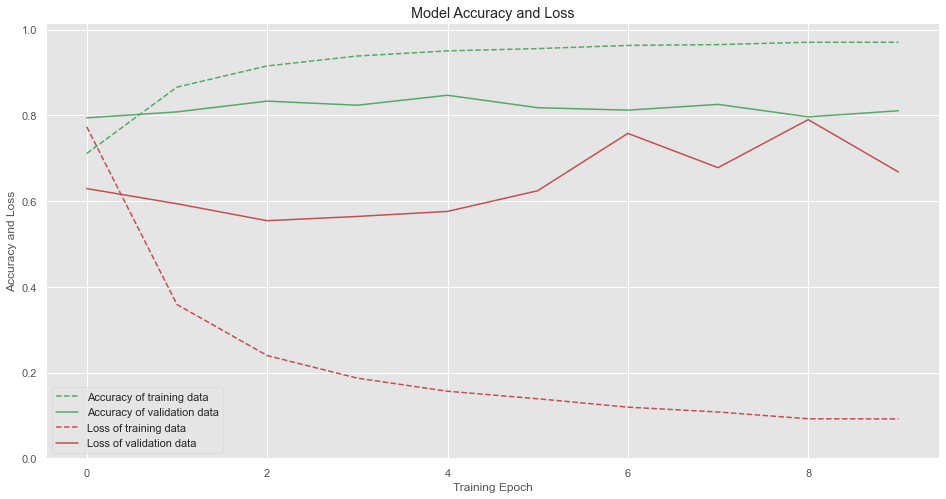

In [19]:
plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


Check against test data

206/206 [==============================] - 1s 4ms/step - loss: 0.4564 - accuracy: 0.9072

Accuracy on test data: 0.91

Loss on test data: 0.46

Confusion matrix for test data



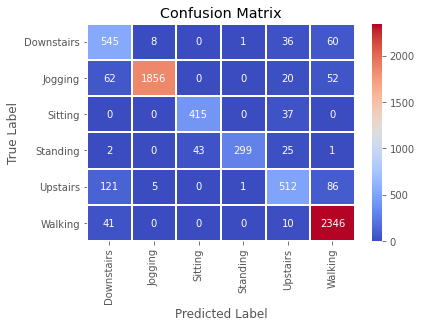


Classification report for test data

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       650
           1       0.99      0.93      0.96      1990
           2       0.91      0.92      0.91       452
           3       0.99      0.81      0.89       370
           4       0.80      0.71      0.75       725
           5       0.92      0.98      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.86      0.87      6584
weighted avg       0.91      0.91      0.91      6584



In [25]:
print("\nCheck against test data\n")

# Normalize 
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test, mw, mw_dist, label)
x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = tku.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])


print("\nConfusion matrix for test data\n")

y_pred = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred = np.argmax(y_pred, axis=1)
max_y_actual = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_actual, max_y_pred)


print("\nClassification report for test data\n")

print(skm.classification_report(max_y_actual, max_y_pred))

### Updated to Python3.8 and TF2 from:

https://github.com/ni79ls/har-keras-cnn